# Evaluation of COSMO testruns with ERA5: bias maps

end-product: maps (COSMO, ERA5 and difference) for  variable and  metric 

In [1]:
import valenspy as vp
from valenspy.processing.regrid import remap_cdo
from valenspy.processing.select import select_region

from valenspy.diagnostic.visualizations import *

import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')

### 0. Settings

In [7]:
# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# reference dataset to compare to
model = 'CCLM'

#variables =  [ 'LHFL_S', 'SHFL_S', 'PS', 'PMSL', 'T_2M', 'TOT_PREC', 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS', 'CLCT', 'CLCL','CLCM','CLCH', 'QV_S', 'T_S',  'QV_S']

In [8]:
# directory with experiments

experiments = ["EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]


In [9]:

def _convert_kg_m2s_to_mm_day(da: xr.DataArray):
    """
    Convert values in xarray DataArray from m hr^-1 to kg m^-2 s^-1s
    """
    # do conversion
    da = da * 86400  # kg m^-2 s^-1 to mm day^-1
    da.attrs["units"] = "mm day-1"

    return da


In [10]:
def load_calc_plot_bias_map(variable: str, ref_dataset: str, experiments: list, months_to_analyse: list, region='europe', freq='hourly',**kwargs): 

    # ------------------------------
    # 1. Load reference data - works for ERA5, CLIMATE_GRID and EOBS

    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset=="ERA5": 
        region_to_load ="europe"
    elif ref_dataset=="ERA5-Land": 
        region_to_load = "belgium"

    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':

        if variable == 'tasmax':        
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').max().rename({'tas':variable})
            gridfile = manager._get_file_paths(ref_dataset,variable_to_load, period=[1995,1995],freq=freq,region=region_to_load)[0]


        elif variable == "tasmin": 
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').min().rename({'tas':variable}) 
            gridfile = manager._get_file_paths(ref_dataset,variable_to_load, period=[1995,1995],freq=freq,region=region_to_load)[0]
        
        elif variable == "pr": 
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region='europe', path_identifiers=["sum"])            
            gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq="daily",region='europe', path_identifiers=["sum"])[0]

        else: 
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq=freq,region=region_to_load)            
       
        if freq == "hourly": 
            ds_obs = ds_obs.resample(time='1D').mean()    

            # retrieve ERA5 gridfile - for regridding 
            gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq=freq,region=region_to_load)[0]
                
    elif ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['latlon_5km'])[0]
        region = 'belgium'

    elif ref_dataset=='EOBS': 
        freq='daily'
        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])[0]

    
    # ------------------------------
    # 2. Load and regrid model data

    for experiment in experiments: 

        print(experiment)

        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"
            variable_mod = "tasmax"

        elif variable == "tasmin": 
            daily_statistic = "min"
            variable_mod = "tas"
        elif variable =="pr": 
            daily_statistic = "sum"
            variable_mod = variable

        else: 
            daily_statistic = "mean"
            variable_mod = variable

        # load data
        ds_mod = manager.load_data(model, [variable_mod], freq="daily", path_identifiers=[experiment, daily_statistic])

        if variable =="tasmax" or variable =="tasmin": 
            ds_mod = ds_mod.rename({'tas':variable}) 

        # ------------------------------
        # 3. Preprocessing: remapping and selection
            
        ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "con")

        # do spatial selection
        ds_mod = select_region(ds_mod, region=region)
        ds_obs = select_region(ds_obs, region=region)

        # select variable and corresponding period
        da_mod = ds_mod[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
        da_obs = ds_obs[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


        da_mod = da_mod.mean('time')
        da_mod.attrs['dataset'] = experiment
        da_obs = da_obs.mean('time')

        if variable == 'pr': 
            da_mod = _convert_kg_m2s_to_mm_day(da_mod)
            da_obs = _convert_kg_m2s_to_mm_day(da_obs)

        da_diff = da_mod - da_obs
        
        ax = plot_maps_mod_ref_diff(da_mod,  da_obs,  da_diff, region=region, **kwargs)


### 2 m temperature

#### ERA 5 

File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_NU_TT_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
EUR11_NU_TT_EC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_EC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValE

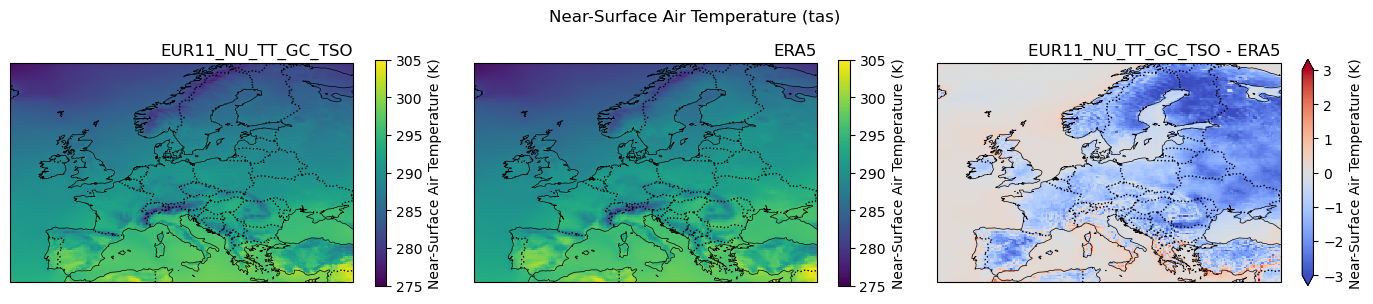

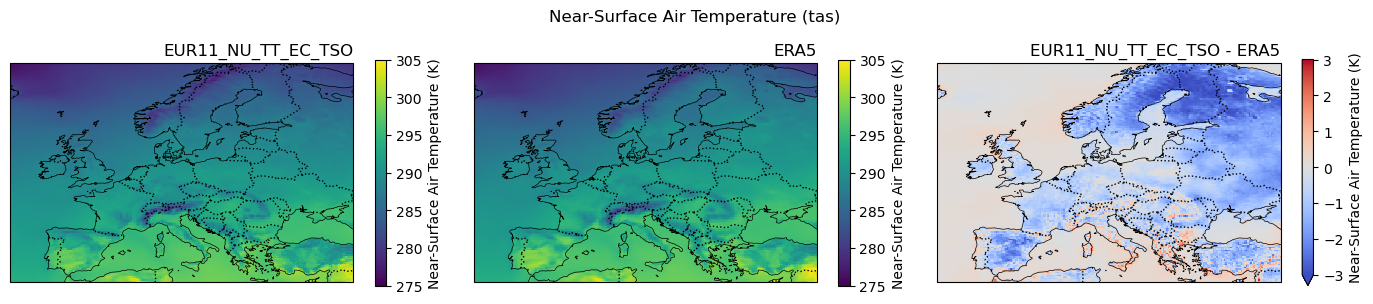

In [11]:
%%time

region = 'europe'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region, vmin=275, vmax=305, vmin_bias=-3, vmax_bias=3)



File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_NU_TT_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
EUR11_NU_TT_EC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_EC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValE

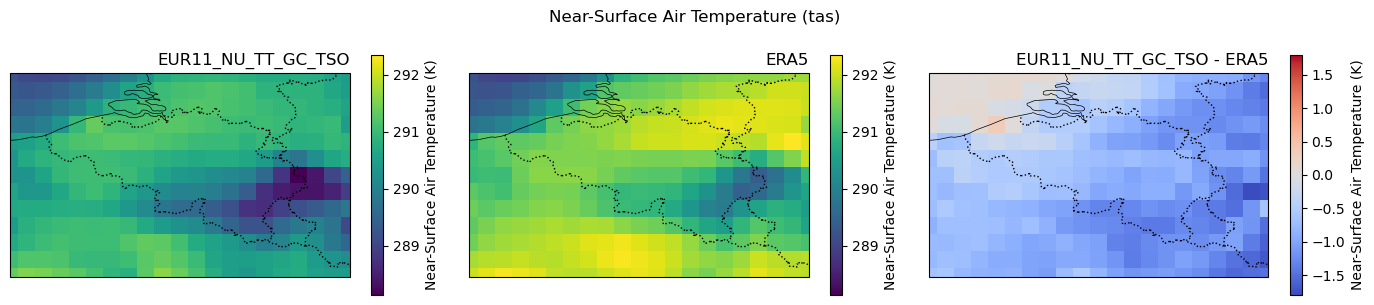

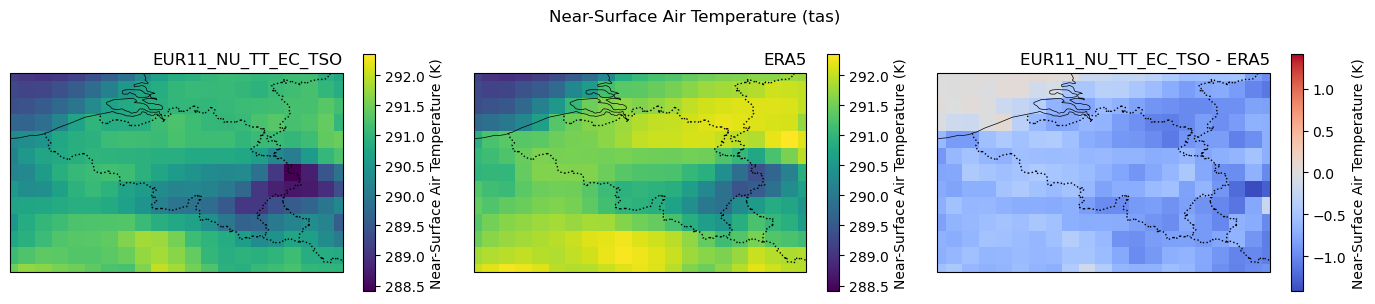

In [12]:
region = 'belgium'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



#### CLIMATE_GRID

File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_NU_TT_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
EUR11_NU_TT_EC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_experiments/EUR11_NU_TT_EC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unkno

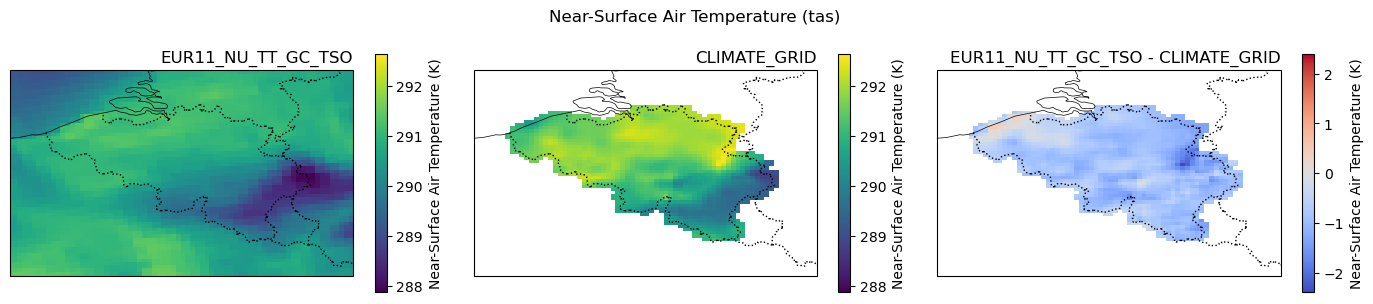

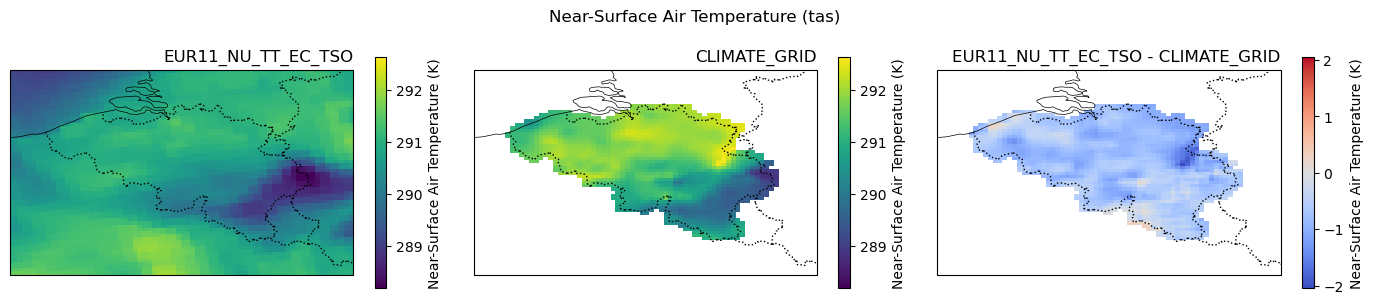

In [13]:
region = 'belgium'
variable = 'tas'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### Maxmimum 2m temperature

#### CLIMATE_GRID

In [14]:
region = 'belgium'
variable = 'tasmax'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_MAX_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tasmax']
EUR11_NU_TT_GC_TSO


FileNotFoundError: No files found for dataset CCLM, variables ['tasmax'], period None, frequency daily, region None and path_identifiers ['EUR11_NU_TT_GC_TSO', 'max'].

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/TEMP_MIN_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tasmin']
EUR11_NU_TT_EC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_NU_TT_EC_TSO/T_2M/daily/T_2M_daymin.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
EUR11_NU_TT_EC_soil
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_NU_TT_EC_soil/T_2M/daily/T_2M_daymin.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 

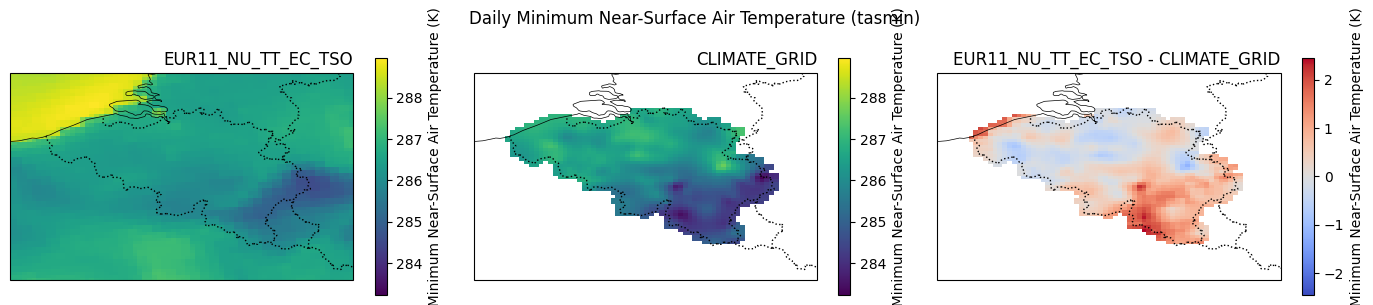

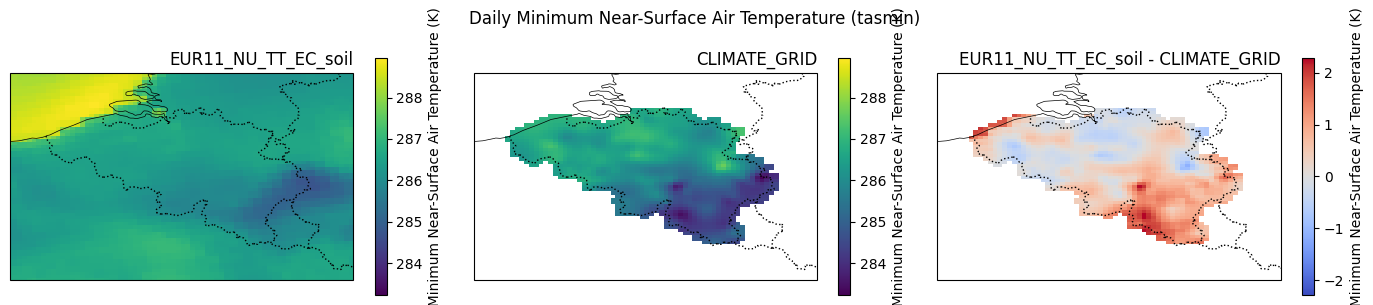

In [ ]:
region = 'belgium'
variable = 'tasmin'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)
